Денис Иванов

Домашняя работа

Поиск аномалий во временном ряде

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import pandas as pd

from ipywidgets import interact, interact_manual
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import OneClassSVM

from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler

In [2]:
series = pd.read_csv("numbers-on-unemployment-benefits.csv")
series.head()

,Month,Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992
0,1956-01,4742.0
1,1956-02,6128.0
2,1956-03,6494.0
3,1956-04,5379.0
4,1956-05,6011.0


In [3]:
series=series.iloc[:,1][:-1]

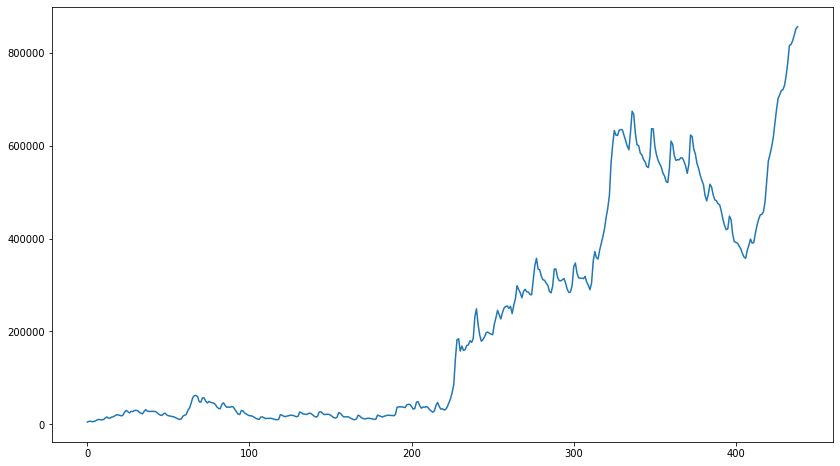

In [4]:
plt.figure(figsize=(14,8))
plt.plot(series)
plt.show()

### 1. Простое мат ожидание

In [5]:
class MeanDetector:
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

In [6]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    plt.figure(figsize=(14,4))
    plt.plot(signal, 'b.')
    plt.plot(signal, 'b-', alpha=0.15)
    plt.title('Signal')
    
    if stop_points:
        plt.vlines(x=stop_points[0], ymin=0, ymax=np.max(signal),
                      colors='r', linestyles='dotted')
    
    plt.show()

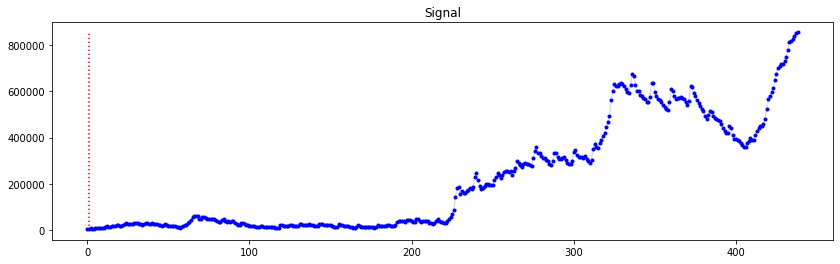

In [7]:
simulate(MeanDetector(), series)

threshold= 1.2


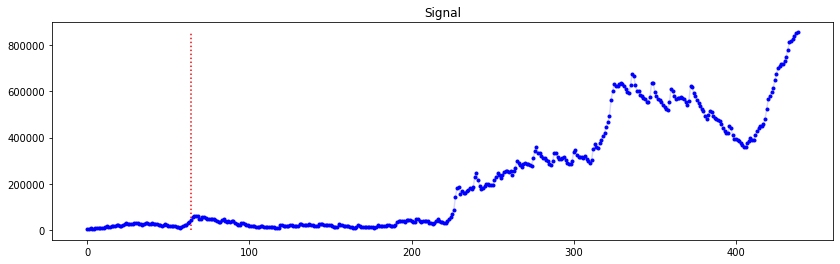

threshold= 3


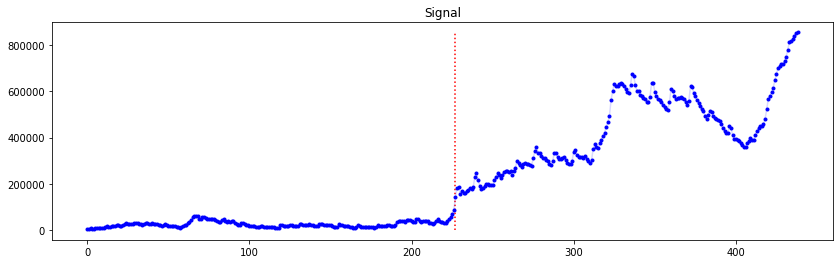

threshold= 5


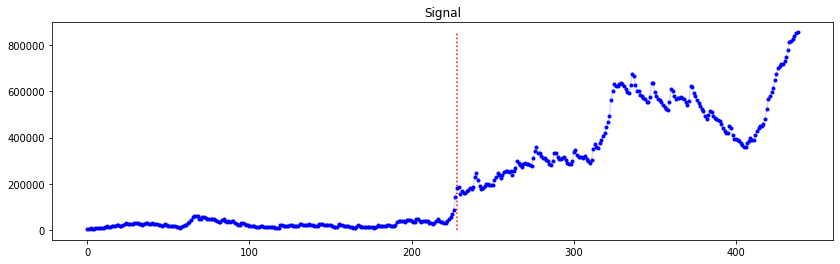

threshold= 7


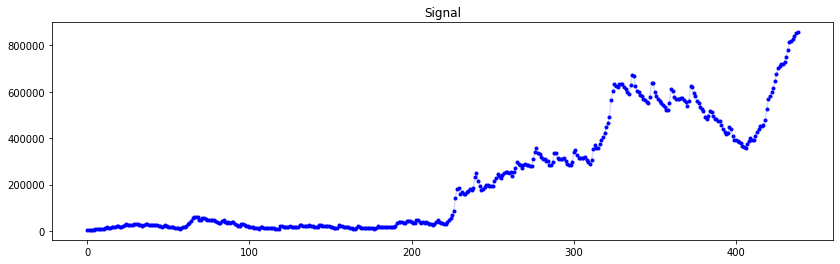

In [8]:
for i in [1.2,3,5,7]:
    print('threshold=',i)
    simulate(MeanDetector(i), series)

Метод применим для Временных рядов со стабильной дисперсией и редкими короткими выбросами

### 2. Потоковые окна

In [9]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

window_size= 200 threshold= 2


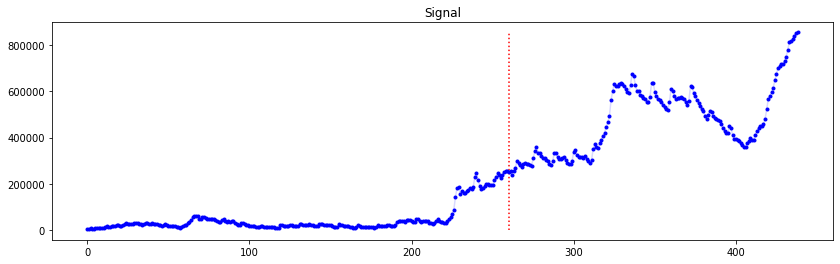

window_size= 200 threshold= 12


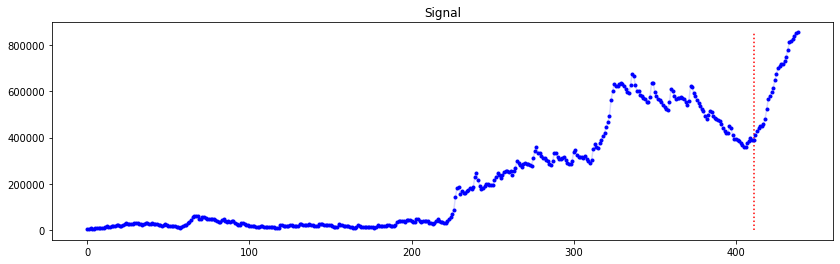

window_size= 52 threshold= 9.5


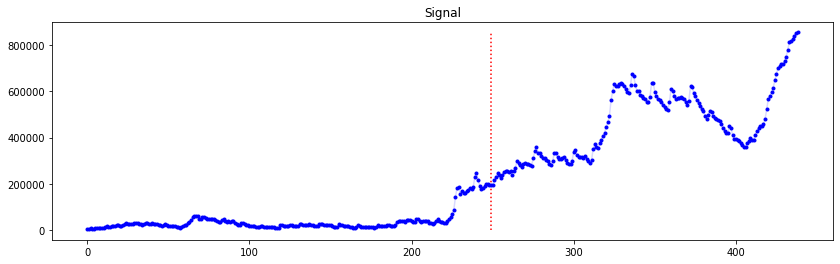

window_size= 34 threshold= 7


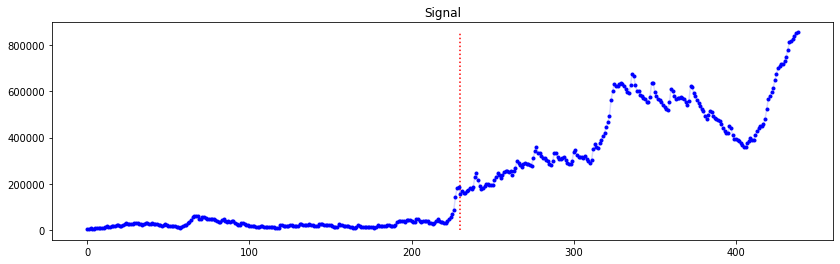

window_size= 16 threshold= 1.5


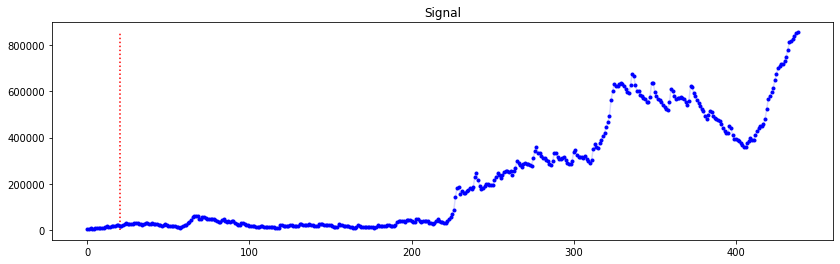

In [10]:
for i,j in zip([200,200,52,34,16],[2,12,9.5,7,1.5]):
    print('window_size=',i,'threshold=',j)
    simulate(ZScoreDetector(window_size=i, threshold=j), series)

### 3.  Кумулятивные суммы

author  = 'Marcos Duarte, https://github.com/demotu/BMC'

version = "1.0.4"

license = "MIT"

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

In [11]:
def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
            
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

threshold= 100000  drift= 250


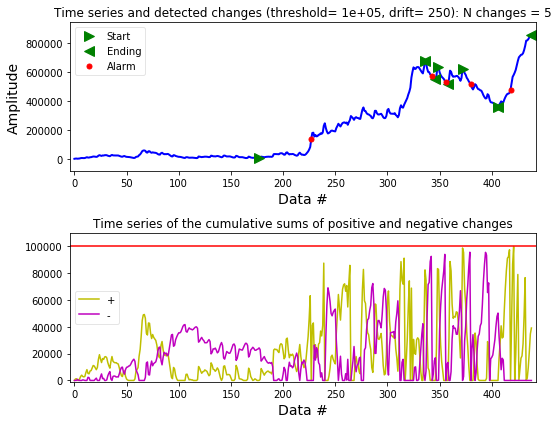

threshold= 200000  drift= 300


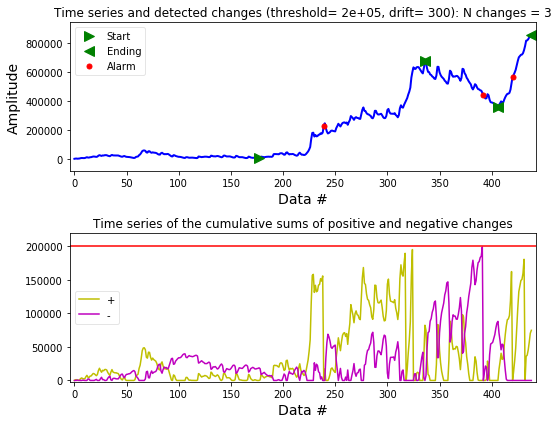

threshold= 300000  drift= 150


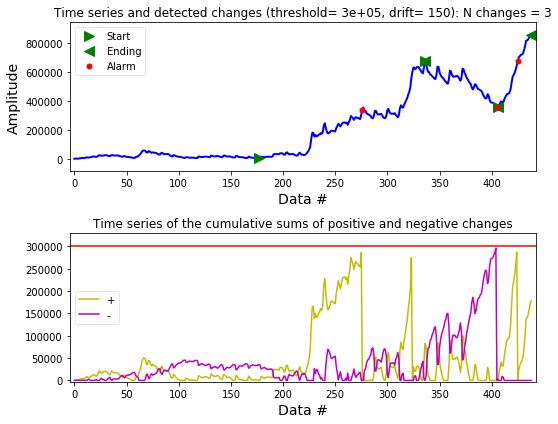

In [12]:
for i,j in zip([100000,200000,300000],[250, 300, 150]):
    print('threshold=',i,' drift=',j)
    detect_cusum(series, i, j, True, True)

### 4.  OneClass SVM


In [13]:
import matplotlib.font_manager
from sklearn import svm

In [14]:
series_for_m4 = np.array(series).reshape(-1, 1)


clf = svm.OneClassSVM(nu=0.9, kernel="rbf", gamma=0.1)
clf.fit(series_for_m4[:350])

y_pred_train = clf.predict(series_for_m4[:350])
y_pred_test  = clf.predict(series_for_m4[350:])

In [15]:
y = np.linspace(0, 800000, 440).reshape(-1, 1)
Z = clf.decision_function(y).reshape(-1, 1)
Z = np.hstack((Z, Z))
y = y.reshape(440)

In [16]:
false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, series_for_m4[i][0]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, series_for_m4[idx][0]))

In [17]:
false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

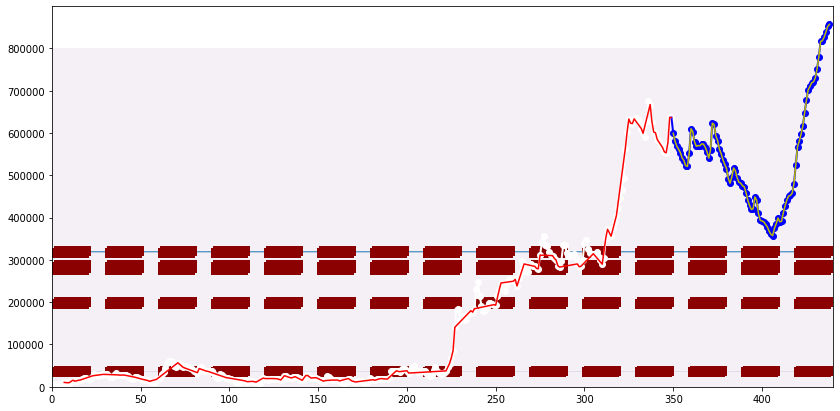

In [18]:
plt.figure(figsize=(14,7))
plt.contourf([0, 440], y, Z, cmap=plt.cm.PuBu)
plt.contour ([0, 440], y, Z, levels=[0], linewidths=10, colors='darkred')

plt.plot(range(350),     series_for_m4[:350], 'wo', linewidth=10)
plt.plot(range(350),     series_for_m4[:350], 'w-', linewidth=2)

plt.plot(range(350,439), series_for_m4[350:], 'bo', linewidth=10)
plt.plot(range(349,439), series_for_m4[349:], 'b-', linewidth=2)

plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'r')
plt.plot(false_positive_test[:, 0],  false_positive_test[:, 1], 'y')
plt.show()

In [19]:
def One_svm_plot(x, g_ma = 0):
    clf = svm.OneClassSVM(nu=0.5, kernel="rbf", gamma=g_ma)
    clf.fit(x[:350])

    y_pred_train = clf.predict(x [:350])
    y_pred_test  = clf.predict(x [350:])

    y = np.linspace(0, 800000, 440).reshape(-1, 1)
    Z = clf.decision_function(y).reshape(-1, 1)
    Z = np.hstack((Z, Z))
    y = y.reshape(440)

    plt.figure(figsize=(14,5))
    plt.contourf([0, 440], y, Z, cmap=plt.cm.PuBu)
    plt.contour ([0, 440], y, Z, levels=[0], linewidths=10, colors='darkred')

    plt.plot(range(350),     x[:350], 'wo', linewidth=5)
    plt.plot(range(350,439), x[350:], 'bo', linewidth=5)

    plt.show()

gamma= 0.001


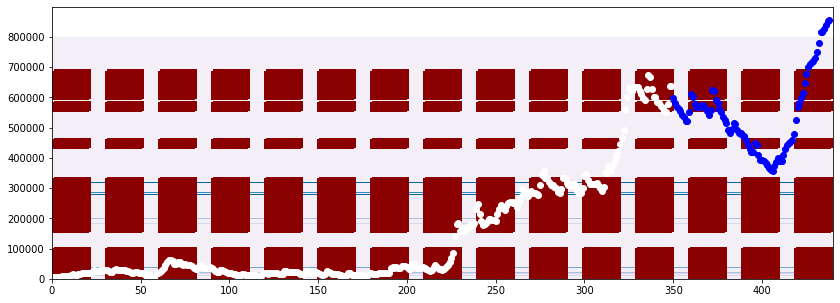

gamma= 0.1


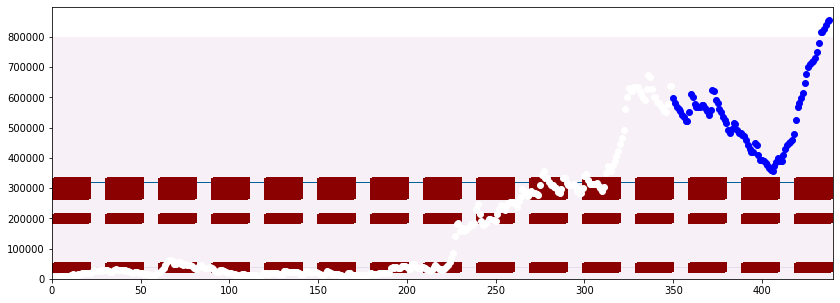

gamma= 1


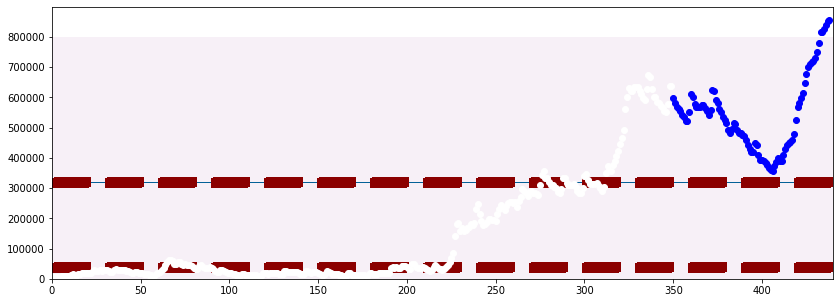

gamma= 5


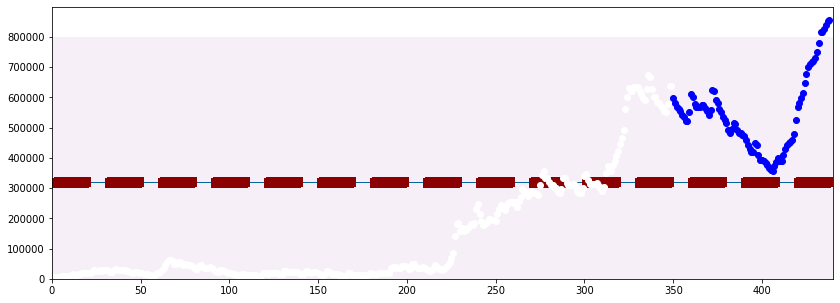

gamma= 15


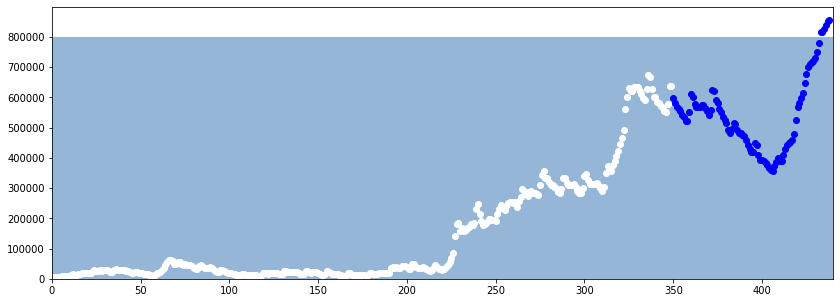

In [20]:
for i in [0.001, 0.1, 1, 5, 15]:
    print('gamma=',i)
    One_svm_plot(series_for_m4, g_ma = i)

In [21]:
series_for_m5 = np.array(series).reshape(-1, 1)

clf = svm.OneClassSVM(nu=0.9, kernel="rbf", gamma=1)
clf.fit(series_for_m5)
y = np.linspace(0, 800000, 440).reshape(-1, 1)
y = y.reshape(440)

positive_predict = []
negative_predict = []

for i, t in enumerate(clf.predict(series_for_m5)):
    if t > 0:
        positive_predict.append((i, series_for_m5[i][0]))
    else:
        negative_predict.append((i, series_for_m5[i][0]))


<function matplotlib.pyplot.show(*args, **kw)>

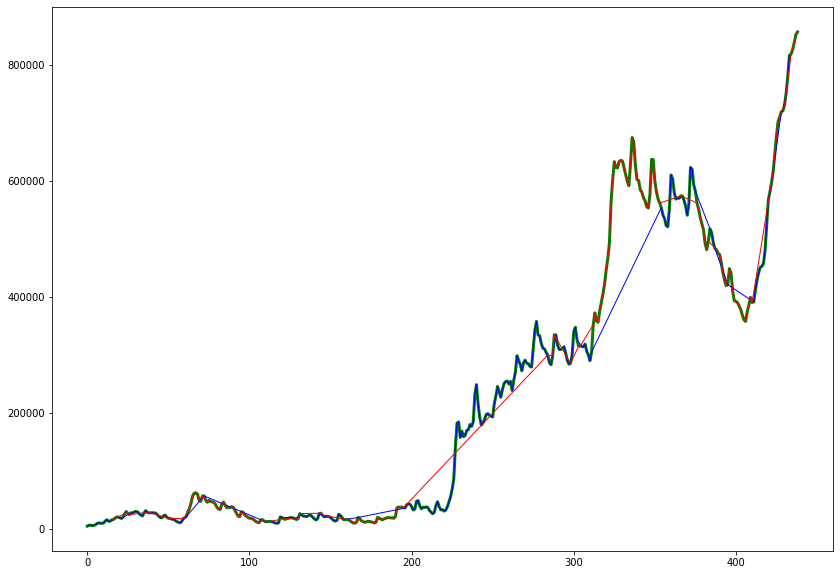

In [22]:
plt.figure(figsize=(14,10))

plt.plot(range(439), series_for_m5, 'g', linewidth=3)

plt.plot([x for x, y in positive_predict], [y for x, y in positive_predict], 'b', linewidth=1)
plt.plot([x for x, y in negative_predict], [y for x, y in negative_predict], 'r', linewidth=1)
plt.show


In [23]:
series_rs = series.values.reshape(-1, 1)

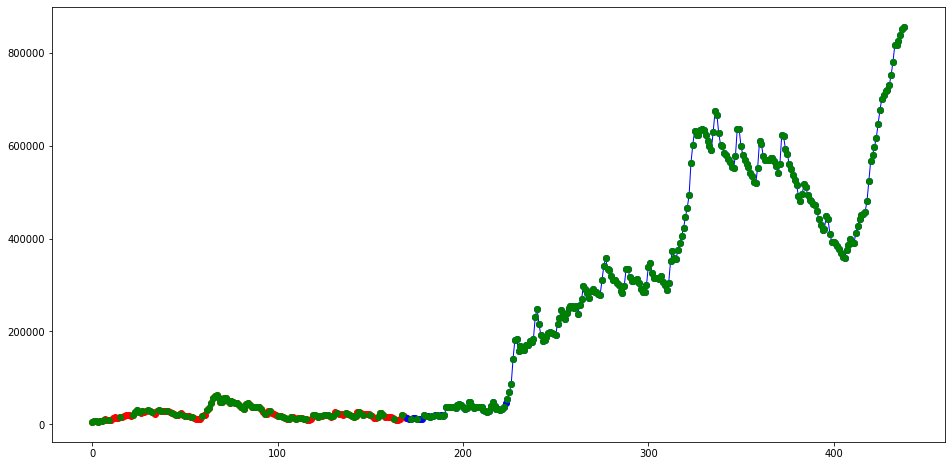

In [24]:
@interact
def simulate_one_class_svm(train_len=(50, 350, 40), nu=(0.01, 1, 0.01), gamma10pow=(-15, 3, 1)):
    series_len = len(series)
    clf = OneClassSVM(nu=nu, kernel="rbf", gamma=10**gamma10pow)
    clf.fit(series_rs[:train_len])

    y_pred_train = clf.predict(series_rs[:train_len])
    y_pred_test = clf.predict(series_rs[train_len:])
    
    y = np.linspace(30, 70, 500).reshape(-1, 1)
    Z = clf.decision_function(y).reshape(-1,1)
    Z = np.hstack((Z, Z))
    y = y.reshape(500)
    
    false_positive_train = []
    false_positive_test = []
    for i, t in enumerate(y_pred_train):
        if t != 1:
            false_positive_train.append((i, series_rs[i]))

    for i, t in enumerate(y_pred_test):
        if t != 1:
            idx = len(y_pred_train) + i
            false_positive_test.append((idx, series_rs[idx]))

    false_positive_train = np.array(false_positive_train)
    false_positive_test = np.array(false_positive_test)

    plt.figure(figsize=(16,8))
    plt.plot(range(train_len), series_rs[:train_len], 'ro', linewidth=2)
    plt.plot(range(train_len), series_rs[:train_len], 'r-', linewidth=1)
    plt.plot(range(train_len, series_len), series_rs[train_len:], 'bo', linewidth=2)
    plt.plot(range(train_len - 1, series_len), series_rs[train_len - 1:], 'b-', linewidth=1)
    plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go', linewidth=2)
    plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
    plt.show()

Обучение на всей выборке

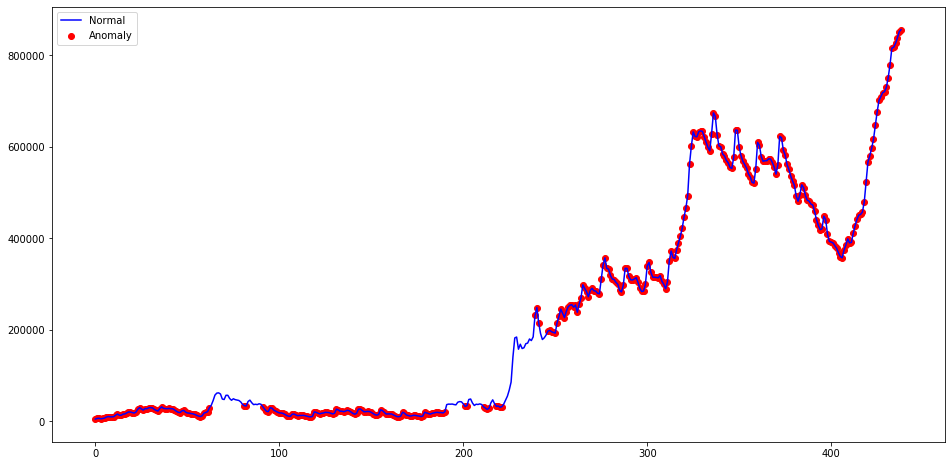

In [25]:
@interact
def simulate_one_class_svm2(outliers=(0.01, 1, 0.01), gamma10pow=(-15, 3, 1)):
    scaler = StandardScaler()
    df_series = pd.DataFrame(series)
    df_series.columns = ['value']
    sc_series = scaler.fit_transform(df_series)
    df_sc_series = pd.DataFrame(sc_series)
    model = OneClassSVM(nu=outliers, kernel="rbf", gamma=10**gamma10pow)
    model.fit(df_sc_series)
    df_series['anomaly'] = pd.Series(model.predict(df_sc_series))
    ig, ax = plt.subplots(figsize=(16,8))

    a = df_series.loc[df_series['anomaly'] == -1, ['value']] #anomaly

    ax.plot(df_series['value'], color='blue', label = 'Normal')
    ax.scatter(a.index, a['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

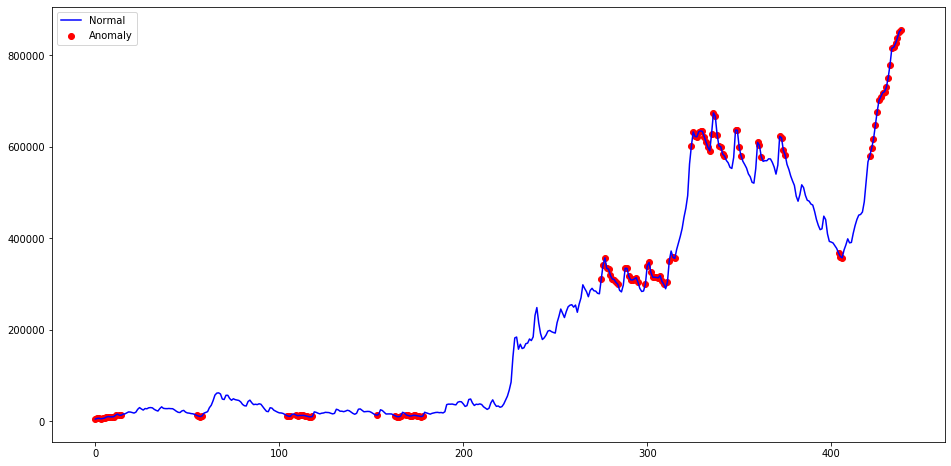

In [26]:
@interact
def simulate_one_class_svm2(outliers=(0, 0.6, 0.01), gamma10pow=(-0.00001, 0.00000010, 0.00001)):
    scaler = StandardScaler()
    df_series = pd.DataFrame(series)
    df_series.columns = ['value']
    sc_series = scaler.fit_transform(df_series)
    df_sc_series = pd.DataFrame(sc_series)
    model = OneClassSVM(nu=outliers, kernel="rbf", gamma=10**gamma10pow)
    model.fit(df_sc_series)
    df_series['anomaly'] = pd.Series(model.predict(df_sc_series))
    ig, ax = plt.subplots(figsize=(16,8))

    a = df_series.loc[df_series['anomaly'] == -1, ['value']] #anomaly

    ax.plot(df_series['value'], color='blue', label = 'Normal')
    ax.scatter(a.index, a['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

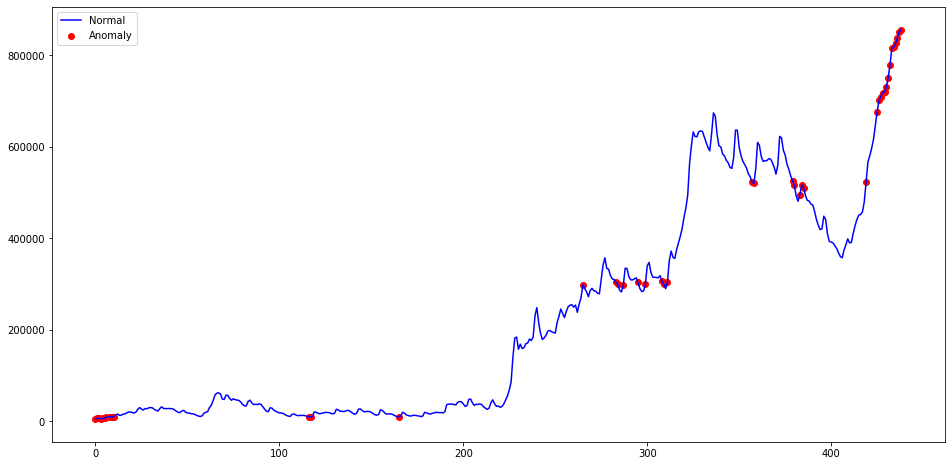

In [27]:
@interact
def simulate_one_class_svm2(outliers=(0, 0.2, 0.000001), 
                            gamma10pow=(-0.00001, 0.00000010, 0.00001)):
    scaler = StandardScaler()
    df_series = pd.DataFrame(series)
    df_series.columns = ['value']
    sc_series = scaler.fit_transform(df_series)
    df_sc_series = pd.DataFrame(sc_series)
    model = OneClassSVM(nu=outliers, kernel="rbf", gamma=10**gamma10pow)
    model.fit(df_sc_series)
    df_series['anomaly'] = pd.Series(model.predict(df_sc_series))
    ig, ax = plt.subplots(figsize=(16,8))

    a = df_series.loc[df_series['anomaly'] == -1, ['value']] #anomaly

    ax.plot(df_series['value'], color='blue', label = 'Normal')
    ax.scatter(a.index, a['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

### 5. IsolationForest


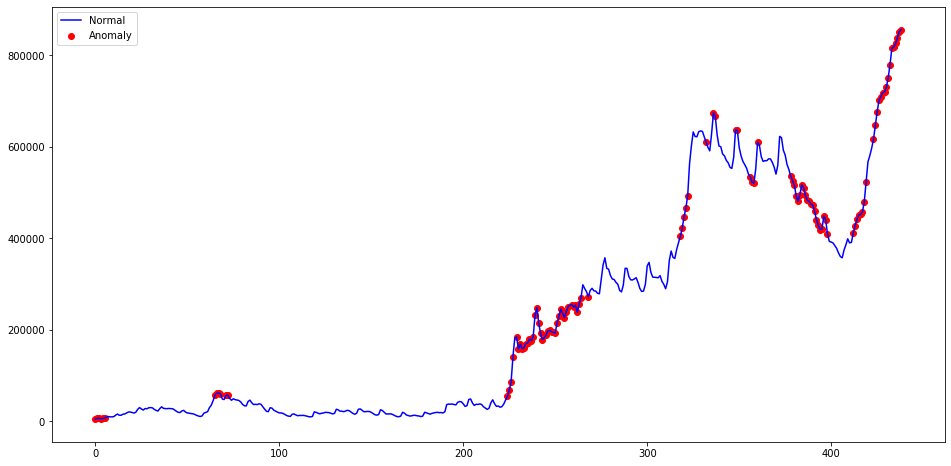

In [28]:
@interact
def simulate_isolation_forest(outliers=(0, 0.5, 0.01)):
    scaler = StandardScaler()
    df_series = pd.DataFrame(series)
    df_series.columns = ['value']
    sc_series = scaler.fit_transform(df_series)
    df_sc_series = pd.DataFrame(sc_series) 
    model = IsolationForest(contamination=outliers)
    model.fit(df_sc_series)
    df_series['anomaly'] = pd.Series(model.predict(df_sc_series))
    ig, ax = plt.subplots(figsize=(16,8))

    a = df_series.loc[df_series['anomaly'] == -1, ['value']] #anomaly

    ax.plot(df_series['value'], color='blue', label = 'Normal')
    ax.scatter(a.index, a['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.show();

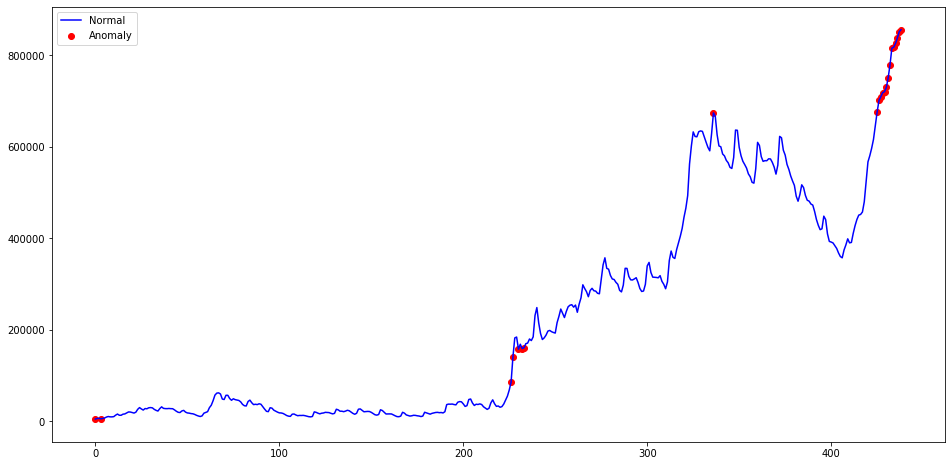

In [29]:
@interact
def simulate_isolation_forest(outliers=(0, 0.1, 0.01)):
    scaler = StandardScaler()
    df_series = pd.DataFrame(series)
    df_series.columns = ['value']
    sc_series = scaler.fit_transform(df_series)
    df_sc_series = pd.DataFrame(sc_series) 
    model = IsolationForest(contamination=outliers)
    model.fit(df_sc_series)
    df_series['anomaly'] = pd.Series(model.predict(df_sc_series))
    ig, ax = plt.subplots(figsize=(16,8))

    a = df_series.loc[df_series['anomaly'] == -1, ['value']] #anomaly

    ax.plot(df_series['value'], color='blue', label = 'Normal')
    ax.scatter(a.index, a['value'], color='red', label = 'Anomaly')
    plt.legend()
    plt.savefig('if.jpeg')
    plt.show();